In [1]:
import pandas as pd 
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cecilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=8):
    print(type(count))
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}

    return top_n_words

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.words('english')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def rescale(x, inplace=False):
    """ Rescale an embedding so oesimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x

In [62]:
sentences_articles = []

path = './data/plots_en'
list_files = os.listdir(path)

articles = pd.DataFrame()
pattern = re.compile(r'== Plot|Synopsis ==\n(.*?)\n== (\S+) ==', re.DOTALL)

for file in list_files:
    if '.txt' not in file:
        continue

    article = open(path + "/" + file, 'r')
    content = article.read()
    
    if content != "":
        sentences_articles.append(content)
    
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(sentences_articles, show_progress_bar=True)
embeddings

Batches: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


array([[-0.04762416, -0.06416631,  0.04684698, ...,  0.06514048,
         0.0819916 , -0.01358245],
       [-0.09199741,  0.11116583,  0.05741924, ..., -0.02743864,
        -0.05278483, -0.0350032 ],
       [-0.03266812, -0.00624627, -0.10377803, ...,  0.05826104,
        -0.02850901, -0.0454992 ],
       ...,
       [-0.12310549,  0.0378999 , -0.03816467, ...,  0.01422468,
        -0.0841239 , -0.06136054],
       [-0.0698892 ,  0.01219623, -0.0459488 , ...,  0.0154292 ,
        -0.0561813 ,  0.0296009 ],
       [ 0.00287237, -0.04724241,  0.09396687, ...,  0.01419075,
        -0.0113945 , -0.02333047]], dtype=float32)

In [26]:
len(embeddings)

471

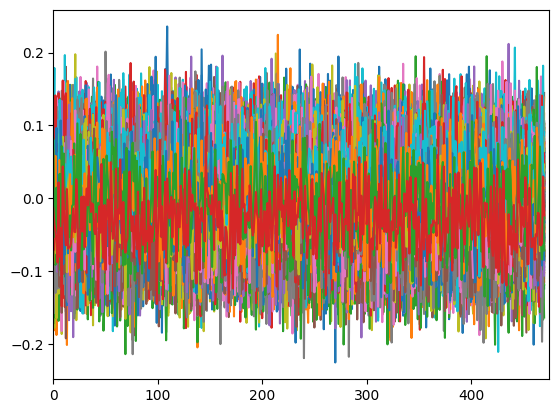

In [4]:
plt.plot(embeddings)
plt.xlim(0, 475)
plt.show()

In [63]:
clustering_kmeans = KMeans(n_clusters=4).fit(embeddings)

In [64]:
from sklearn.manifold import TSNE
# Random state we define this random state to use this value in TSNE which is a randmized algo.
Y = clustering_kmeans.labels_
RS = 25111993
digits_proj = TSNE(random_state=42, perplexity=355).fit_transform(embeddings)

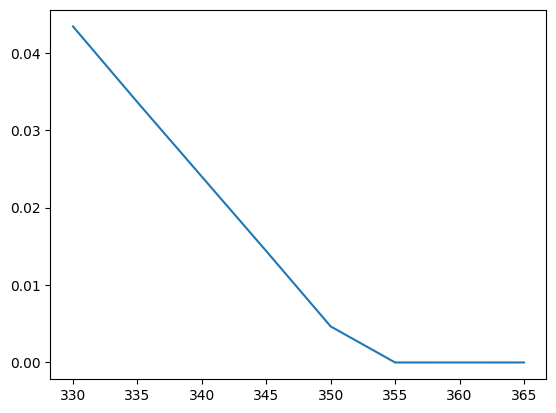

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.express as px

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, random_state=13, test_size=0.25, shuffle=True
)

perplexity = np.arange(330, 370, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)

# fig = plt.figure()
# ax = plt.axes()
plt.plot(perplexity, divergence)
# fig = px.line(x=perplexity, y=divergence, markers=True)
# fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
# fig.update_traces(line_color="red", line_width=1)
plt.show()

In [69]:
d = {}
clusters_d = {}
for i in range(len(embeddings)):
    # d[list_files[i]] = Y[i]
    if Y[i] not in clusters_d.keys():
        clusters_d[Y[i]] = []
    clusters_d[Y[i]].append(list_files[i])

with open("clusters_embeddings.txt", "a") as f:
    f.write(str(clusters_d))
#4: descrição de biografias, ficcionais ou não
for k, v in clusters_d.items():
    print(len(v))

153
86
99
133


Text(0.5, 1.0, 'Clusters da seção "Plot" dos artigos em inglês')

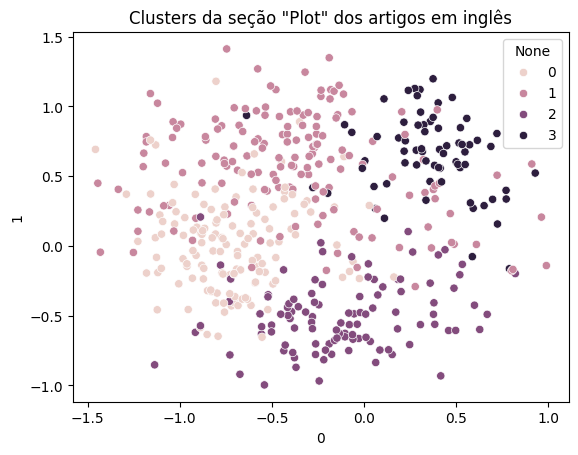

In [18]:
tsne_df =  pd.DataFrame(digits_proj, Y)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('Clusters da seção "Plot" dos artigos em inglês')

In [19]:
import matplotlib.patheffects as PathEffects

# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("Paired", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(15, 7))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(int)])
    plt.colorbar(sc)
    plt.title("Clusters da seção 'Plot' dos artigos em inglês", fontsize=20)
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

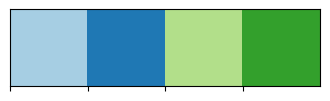

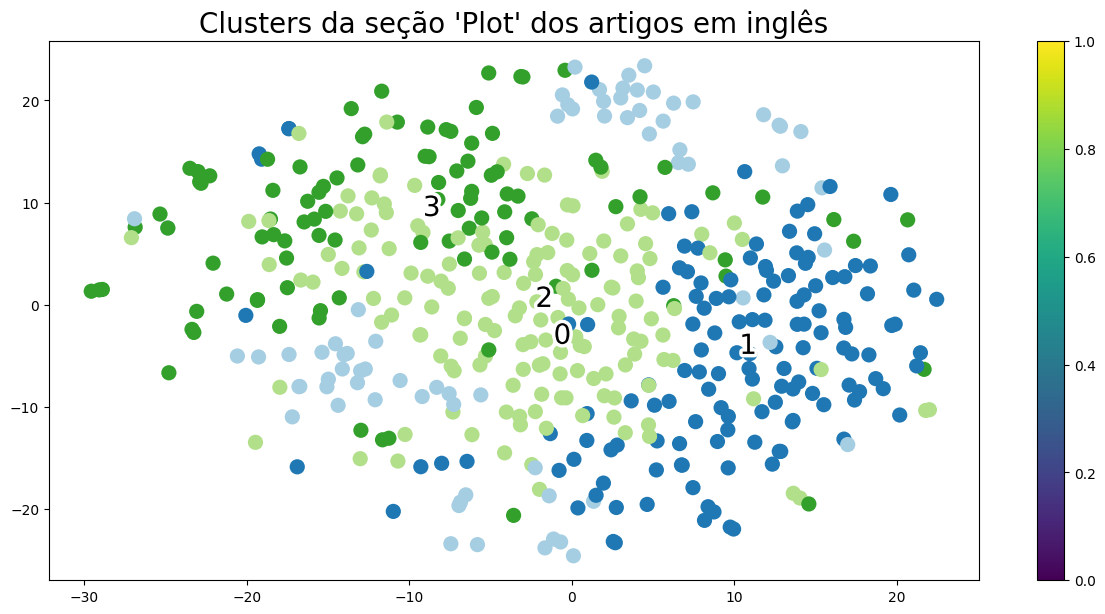

In [21]:
sns.palplot(np.array(sns.color_palette("Paired", 4)))
scatter(digits_proj, Y)
plt.savefig('resultados embedding + tsne inglês.png', dpi=120)
plt.show()

In [70]:
sentences_articles = []

path = './data/plots_es'
list_files = os.listdir(path)

articles = pd.DataFrame()
pattern = re.compile(r'== Plot|Synopsis ==\n(.*?)\n== (\S+) ==', re.DOTALL)

for file in list_files:
    if '.txt' not in file:
        continue

    article = open(path + "/" + file, 'r')
    content = article.read()
    
    if content != "":
        sentences_articles.append(content)
    
sentence_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v1")
embeddings = sentence_model.encode(sentences_articles, show_progress_bar=True)
embeddings

Batches: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


array([[-0.00750416,  0.01531543,  0.08852476, ...,  0.01493121,
         0.00952806, -0.06489311],
       [ 0.00815409, -0.00077002, -0.03948041, ...,  0.01055519,
         0.03511779, -0.02277049],
       [ 0.01530439,  0.04027545,  0.08923031, ..., -0.02896978,
        -0.05092917, -0.04022365],
       ...,
       [-0.01981023, -0.03789463, -0.00613708, ...,  0.01570242,
         0.01141714,  0.01603906],
       [ 0.01848864, -0.01737466,  0.02410335, ..., -0.02614825,
        -0.01532297,  0.00721818],
       [ 0.00967451,  0.02511765,  0.02299971, ...,  0.02192456,
         0.01691841, -0.00384115]], dtype=float32)

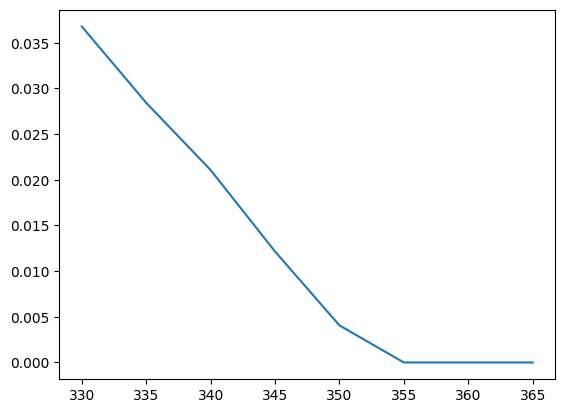

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.express as px

clustering_kmeans = KMeans(n_clusters=4).fit(embeddings)
Y = clustering_kmeans.labels_

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, random_state=13, test_size=0.25, shuffle=True
)

perplexity = np.arange(330, 370, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)

# fig = plt.figure()
# ax = plt.axes()
plt.plot(perplexity, divergence)
# fig = px.line(x=perplexity, y=divergence, markers=True)
# fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
# fig.update_traces(line_color="red", line_width=1)
plt.show()

In [71]:
clustering_kmeans = KMeans(n_clusters=4).fit(embeddings)

In [72]:
from sklearn.manifold import TSNE
# Random state we define this random state to use this value in TSNE which is a randmized algo.
Y = clustering_kmeans.labels_
RS = 25111993
digits_proj = TSNE(random_state=42, perplexity=355).fit_transform(embeddings)

In [73]:
d = {}
clusters_d = {}
for i in range(len(embeddings)):
    # d[list_files[i]] = Y[i]
    if Y[i] not in clusters_d.keys():
        clusters_d[Y[i]] = []
    clusters_d[Y[i]].append(list_files[i])

with open("clusters_embeddings.txt", "a") as f:
    f.write(str(clusters_d))

#4: descrição de biografias, ficcionais ou não
for k, v in clusters_d.items():
    print(len(v))

133
107
139
92


Text(0.5, 1.0, 'Clusters da seção "Argumento" dos artigos em espanhol')

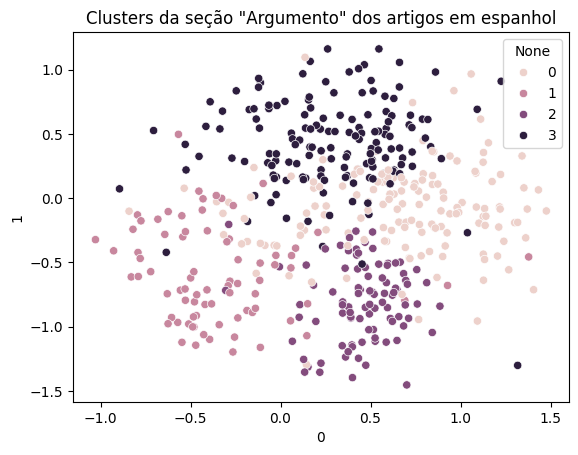

In [24]:
tsne_df =  pd.DataFrame(digits_proj, Y)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('Clusters da seção "Argumento" dos artigos em espanhol')

In [30]:
import matplotlib.patheffects as PathEffects

# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("Paired", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(15, 7))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(int)])
    plt.colorbar(sc)
    plt.title("Clusters da seção 'Argumento' dos artigos em espanhol", fontsize=20)
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

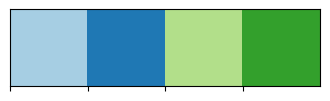

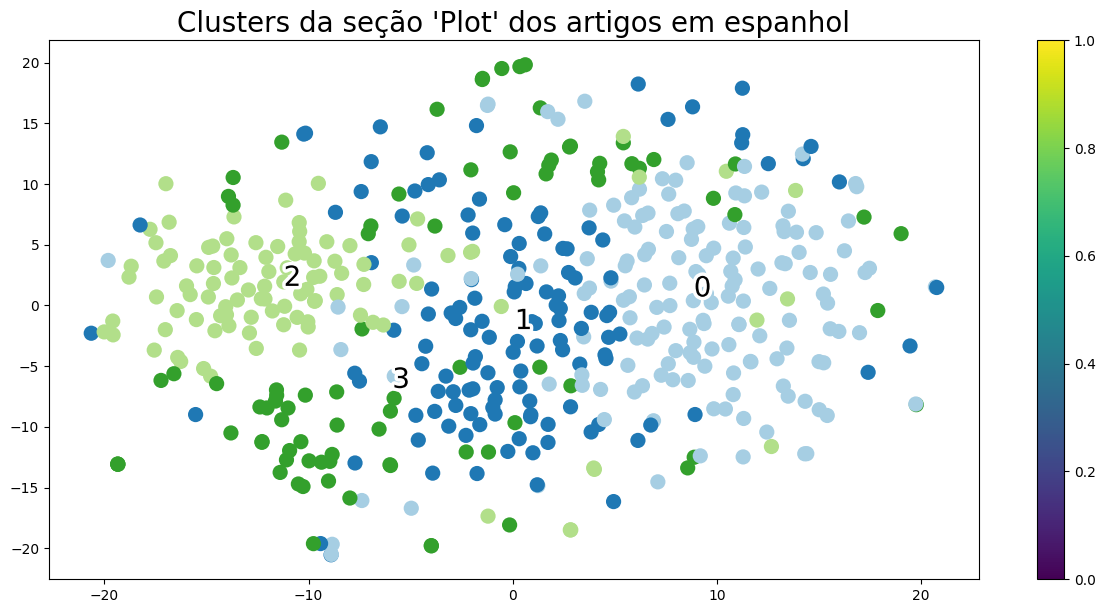

In [31]:
sns.palplot(np.array(sns.color_palette("Paired", 4)))
scatter(digits_proj, Y)
plt.savefig('resultados embedding + tsne espanhol.png', dpi=120)
plt.show()

In [78]:
sentences_articles = []

path = './data/plots_pt'
list_files = os.listdir(path)

articles = pd.DataFrame()
pattern = re.compile(r'== Plot|Synopsis ==\n(.*?)\n== (\S+) ==', re.DOTALL)

for file in list_files:
    if '.txt' not in file:
        continue

    article = open(path + "/" + file, 'r')
    content = article.read()
    
    if content != "":
        sentences_articles.append(content)
    
sentence_model = SentenceTransformer("rufimelo/Legal-BERTimbau-large-TSDAE-v4-sts")
embeddings = sentence_model.encode(sentences_articles, show_progress_bar=True)
embeddings

Batches: 100%|██████████| 15/15 [02:11<00:00,  8.78s/it]


array([[-0.06071116,  0.28856507,  0.23622896, ...,  0.18059514,
         0.26029736,  0.36573523],
       [ 0.1537686 , -1.1595266 ,  0.1070031 , ...,  0.06901994,
        -1.0114195 , -0.12657239],
       [ 0.6191471 , -0.7036963 ,  1.1270355 , ...,  0.9504181 ,
        -0.8405973 , -0.09039246],
       ...,
       [-0.23505394, -0.28777307, -0.50264925, ...,  0.27865642,
         0.45374715,  0.6651248 ],
       [ 0.5864808 , -1.648687  , -0.41422454, ...,  0.4685328 ,
        -1.5779184 , -0.5237917 ],
       [ 0.49062195, -1.0606176 ,  0.4630121 , ..., -0.44407922,
         0.2989828 , -0.05777376]], dtype=float32)

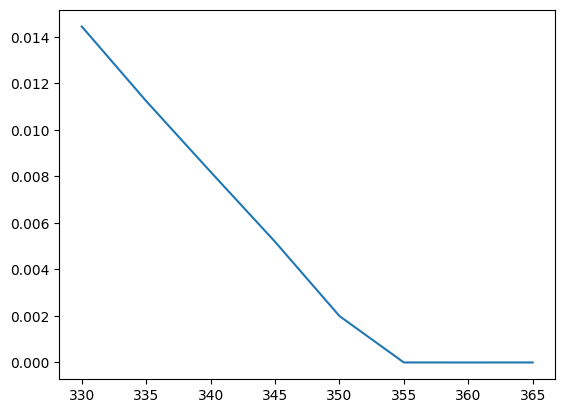

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.express as px

clustering_kmeans = KMeans(n_clusters=4).fit(embeddings)
Y = clustering_kmeans.labels_

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, random_state=13, test_size=0.25, shuffle=True
)

perplexity = np.arange(330, 370, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)

# fig = plt.figure()
# ax = plt.axes()
plt.plot(perplexity, divergence)
# fig = px.line(x=perplexity, y=divergence, markers=True)
# fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
# fig.update_traces(line_color="red", line_width=1)
plt.show()

In [79]:
clustering_kmeans = KMeans(n_clusters=5).fit(embeddings)

In [80]:
from sklearn.manifold import TSNE
# Random state we define this random state to use this value in TSNE which is a randmized algo.
Y = clustering_kmeans.labels_
RS = 25111993
digits_proj = TSNE(random_state=42, perplexity=355).fit_transform(embeddings)

In [81]:
d = {}
clusters_d = {}
for i in range(len(embeddings)):
    # d[list_files[i]] = Y[i]
    if Y[i] not in clusters_d.keys():
        clusters_d[Y[i]] = []
    clusters_d[Y[i]].append(list_files[i])

with open("clusters_embeddings.txt", "a") as f:
    f.write(str(clusters_d))

#4: descrição de biografias, ficcionais ou não
for k, v in clusters_d.items():
    print(len(v))
# x = []
# for key, value in d.items():
#     if value == 1:
#         x.append(key)
# x

144
67
61
114
85


Text(0.5, 1.0, 'Clusters da seção "Enredo" dos artigos em português')

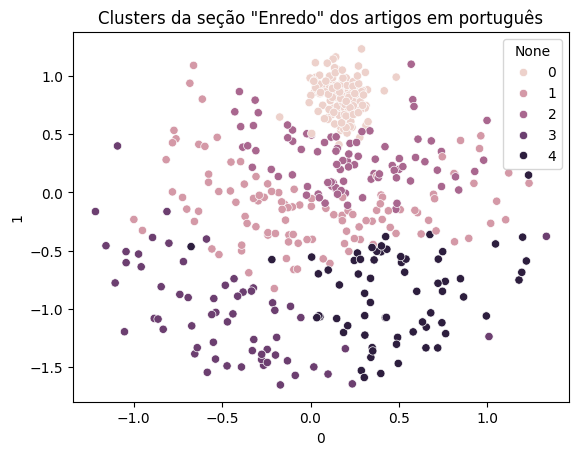

In [82]:
tsne_df =  pd.DataFrame(digits_proj, Y)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('Clusters da seção "Enredo" dos artigos em português')

In [40]:
import matplotlib.patheffects as PathEffects

# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("Paired", 5))

    # We create a scatter plot.
    f = plt.figure(figsize=(15, 7))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(int)])
    plt.colorbar(sc)
    plt.title("Clusters da seção 'Plot' dos artigos em português", fontsize=20)
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(5):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

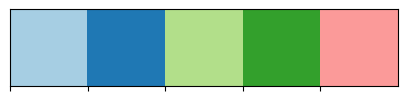

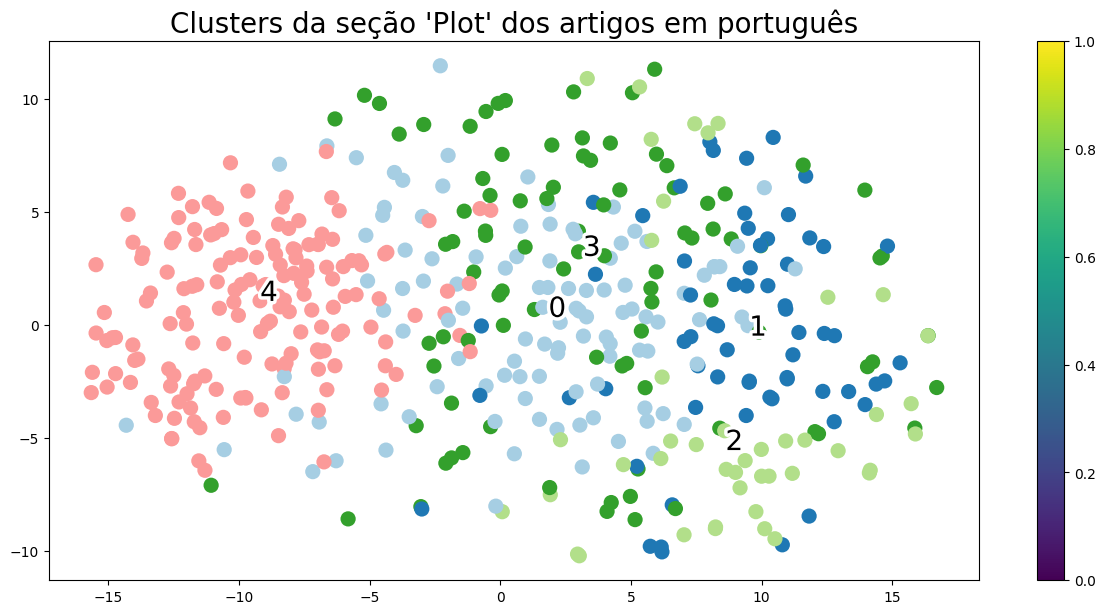

In [41]:
sns.palplot(np.array(sns.color_palette("Paired", 5)))
scatter(digits_proj, Y)
plt.savefig('resultados embedding + tsne português.png', dpi=120)
plt.show()